# Spam Email Detector System

## Phase1: Problem Understanding and Data Exploration

### 1. Problem Definition
Spam emails are one of the most common online issues.
They often contain scams, phishing links, or unwanted advertisements that can put users at risk.

The main problem is to automatically detect and classify emails as spam or not spam (ham) based on their text content.
This helps reduce user exposure to unsafe or irrelevant messages.


### 2. Scope

- Focuses on **text data** only (no images or attachments).  
- Initially handles **English-language messages**.  
- Provides **real-time or batch classification** of messages.  

### 3. Team Role Distribution — Phase 1

| Member | Role | Responsibilities |
|---------|------|------------------|
|  [fajr alkatheri] | **Data Cleaning & Handling Missing Values** | Checked, filled, and standardized missing data. Ensured dataset consistency and exported cleaned version. |
| [renad] | **Feature Extraction** | Analyzed columns, decided which features to keep/drop, and created new features |
| [rahaf & rawan] | **Text Preprocessing** | Cleaned email body (remove HTML tags, symbols), applied tokenization, normalized casing. |
| [salha] | **Text Representation (Vectorization)** | Researched and implemented different text representation methods (TF-IDF, CountVectorizer). |


### 4. Dataset Overview

**Data Source Options:**  
- [Phishing Email Dataset](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset)  

**Data Columns:**  
- `sender`: Email or phone number of the message sender  
- `receiver`: Recipient email or phone number  
- `date`: Timestamp of the message  
- `subject`: Subject line of the message  
- `body`: Main content of the message (text)  
- `label`: `if its spam 1` or `0` (number)  
- `urls`: `if it contains a URL 1` or `0` (number)  
 

### 5. Project Objective  
This project aims to create a system that can automatically classifies incoming text messages or emails as **spam** or **not spam (ham)**.   
It helps users know which messages are safe to open and which ones might be unwanted or risky.  

Specifically, it will:  
- Analyze the content of emails or SMS messages.  
- Label messages as spam or ham.  
- Help protect users from scams, phishing, and unwanted advertisements.  

It works as a **binary classification model** that uses **text data** to make its predictions.  


---






---
---

# pre-process flow مسودة ونوتات ريناد

### sender / receiver: Optional to keep, mostly metadata

### subject / body: Critical for spam detection.

### Missing body → drop row  or replace with empty string?.

### Missing subject → replace with empty string.

### urls / label: Must not be missing. Drop any row missing these.

### 2. Feature Extraction / Engineering
### 1. Combine subject + body into a single text field for modeling i think for text represention as a vector
### 2. extract text length as a numeric feature a new column
### 3. maybe another column that counts a word occurence and all captical words in a text
### 4. Sender/Receiver metadata (optional)

### Could extract domains from email addresses: "gmail.com", "yahoo.com", etc.

### Could count frequency of sender → some frequent spammers.

# 3. Text Preprocessing (NLP)

### This is key for the text column (subject + body): i think we should combine it

### 1.Cleaning

### Remove HTML tags, punctuation, extra whitespace.

### Keep uppercase info optionally (important for spam detection).

### 2.Tokenization

### Split text into words.

### Stopword handling

### Optional: sometimes keeping stopwords is better for spam detection.?

### 3.Stemming / Lemmatization idk maybe not? for better detection ?


### 4.Feature representation

### Convert to numeric vectors: TF-IDF, Bag-of-Words, or word embeddings for model input.

### Step 1: Set Up the Environment  

We started by importing the necessary Python libraries and loading our dataset into a pandas DataFrame.  
This step ensures that our environment is working correctly and that the dataset can be accessed for further analysis.  

#### Code:


In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("CEAS_08.csv")
df.head()
#if lable 1 its a scamming email if 0 no

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [3]:
len(df)

39154

In [4]:
print("detailed:", df.shape, df['label'].value_counts())

detailed: (39154, 7) label
1    21842
0    17312
Name: count, dtype: int64


**Summary:**  
The dataset contains **39,154 rows and 7 columns**.  
It includes **21,842 spam (1)** and **17,312 ham (0)** messages, showing a relatively balanced distribution between the two classes.



---

### Step 2: Exploring the Dataset  

Quick look at the data to check size and class balance before cleaning.

In [5]:
# Shape + label balance 
print("Shape:", df.shape)
label_counts = df["label"].value_counts().sort_index()  # 0, 1
print("Label counts:\n", label_counts)

Shape: (39154, 7)
Label counts:
 label
0    17312
1    21842
Name: count, dtype: int64



**Summary:**  
The dataset contains **39,154 rows** and **7 columns**.  
There are slightly more spam emails (label 1) than ham emails (label 0), but the classes are fairly balanced overall.  

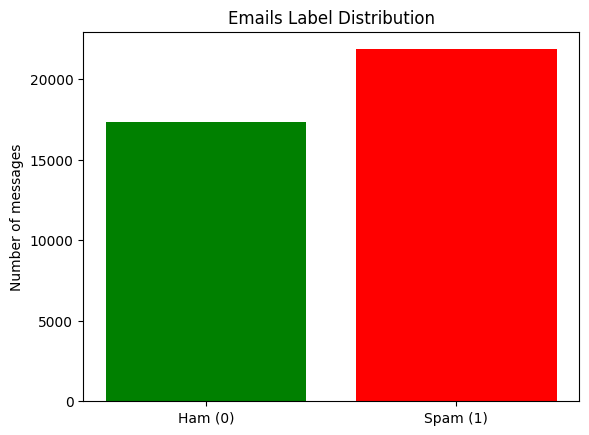

In [6]:
# Bar chart: label distribution (from the data)
import matplotlib.pyplot as plt

labels = ["Ham (0)", "Spam (1)"]
counts = label_counts.reindex([0, 1], fill_value=0).values

plt.bar(labels, counts, color=['green', 'red'])  # Ham = orange, Spam = red/salmon
plt.title("Emails Label Distribution")
plt.ylabel("Number of messages")
plt.show()

**Summary:**  
The chart shows the two classes are close in size, which is good for training.

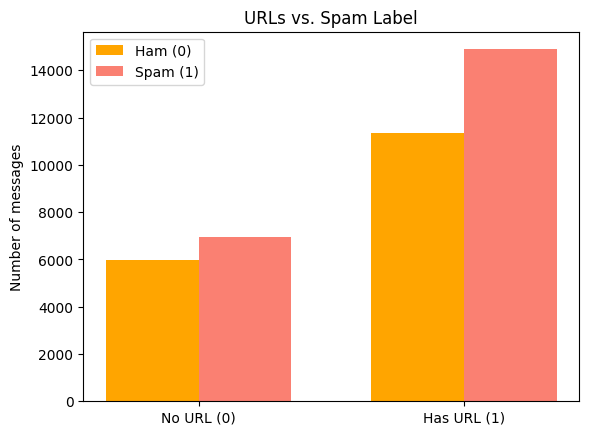

In [7]:
# Explore if URLs affect spam likelihood (no seaborn)
import matplotlib.pyplot as plt

url_table = (
    df.groupby(["urls", "label"])
      .size()
      .unstack(fill_value=0)
      .reindex(index=[0, 1], fill_value=0)
)

x = [0, 1]  # 0 = no URL, 1 = has URL
ham = url_table.get(0, [0, 0]).values
spam = url_table.get(1, [0, 0]).values

width = 0.35
plt.figure()
plt.bar([i - width/2 for i in x], ham, width, color='orange', label="Ham (0)")
plt.bar([i + width/2 for i in x], spam, width, color='salmon', label="Spam (1)")
plt.xticks(x, ["No URL (0)", "Has URL (1)"])
plt.title("URLs vs. Spam Label")
plt.ylabel("Number of messages")
plt.legend()
plt.show()

**Summary:**  
This chart shows how the presence of URLs in an email relates to whether it’s spam or not.  
We noticed that most spam emails contain URLs, which makes sense since phishing and scam messages often include links.  

---

### Step 3: Data Cleaning and Handling Missing Values 

In this step, we cleaned the dataset to make sure it’s complete and consistent before moving forward.  
We mainly focused on handling missing values, fixing data types, and ensuring that important columns don’t contain empty or invalid data.


In [8]:
# We’ll use a helper function (missing_report) to display the missing count and percentage clearly.

def missing_report(frame):
    mc = frame.isna().sum()
    mp = (frame.isna().mean() * 100).round(2)
    rep = (
        pd.concat([mc.rename("Missing Count"), mp.rename("Missing %")], axis=1)
        .sort_values("Missing %", ascending=False)
    )
    return rep

missing_before = missing_report(df)
missing_before


,Missing Count,Missing %
receiver,462,1.18
subject,28,0.07
sender,0,0.00
date,0,0.00
body,0,0.00
label,0,0.00
urls,0,0.00


**Observation:**  
We found a small percentage of missing data:
- `receiver` column has around **1.18%** missing values.  
- `subject` column has around **0.07%** missing values.  
- All other columns are complete (`body`, `label`, `urls`, `date`, and `sender`).  

**Handling Missing Values Code:**

In [9]:
# Handle missing values carefully
# receiver: replace missing with empty string ("") to avoid bias
# subject: replace missing with "No Subject" since many real emails have no subject

df['receiver'] = df['receiver'].fillna("")
df['subject'] = df['subject'].fillna("No Subject")

# Verify again
missing_after = missing_report(df)
missing_after


,Missing Count,Missing %
sender,0,0.0
receiver,0,0.0
date,0,0.0
subject,0,0.0
body,0,0.0
label,0,0.0
urls,0,0.0


**Explanation**

For the `receiver` column, we decided to fill missing values with an empty string (`""`) instead of a fake email.  
We first considered adding a placeholder such as `"unknown@gvc.ceas-challenge.cc"`,  
but we realized this could make the model learn a false pattern. 

For the subject column, we replaced missing values with "No Subject" since some real emails don’t have a subject line.


**checking data types** :

In [10]:
# Inspect dtypes before fixing
print("Dtypes BEFORE:\n", df.dtypes, "\n")

# Quick peek at unique values for binary columns (if present)
for col in ["label", "urls"]:
    if col in df.columns:
        print(f"Unique values in `{col}` (sample):", df[col].dropna().unique()[:10])


Dtypes BEFORE:
 sender      object
receiver    object
date        object
subject     object
body        object
label        int64
urls         int64
dtype: object 

Unique values in `label` (sample): [1 0]
Unique values in `urls` (sample): [1 0]


**Summary:**  
We checked the data types of all columns to make sure they were correctly recognized.  
Both `label` and `urls` columns contained only 0 and 1 values, which confirms they are properly encoded as binary features.  

**Cleaning Text Columns** :

In [11]:
# Clean and standardize text columns
text_cols = [c for c in ["sender", "receiver", "subject", "body"] if c in df.columns]

for col in text_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()                # remove leading/trailing spaces
        .str.replace(r"\s+", " ", regex=True)  # collapse multiple spaces
    )

print("✅ Text fields cleaned (trimmed and normalized).")


✅ Text fields cleaned (trimmed and normalized).


**Result:**  
All text-based columns (`sender`, `receiver`, `subject`, `body`) were converted to clean, uniform strings.  
Extra whitespace was removed, and spacing was normalized.  
This ensures the text is ready for NLP preprocessing in the next phase.


**final verification after cleaning** :

In [12]:
# 1) No missing values anywhere
missing_after = df.isna().sum().sort_values(ascending=False)
print("Missing values per column (AFTER):\n", missing_after, "\n")
assert missing_after.sum() == 0, "There are still missing values. Please review."

# 2) Dtypes look sensible
print("Dtypes AFTER:\n", df.dtypes, "\n")

# 3) Binary columns contain only 0/1
for col in ["label", "urls"]:
    if col in df.columns:
        uniq = sorted(df[col].unique().tolist())
        print(f"Unique values in `{col}`:", uniq)
        assert set(uniq).issubset({0, 1}), f"{col} must be binary 0/1."

# 4) Quick sanity on text: show a few cleaned samples
display(df.sample(5, random_state=7)[["sender","receiver","subject","body","label","urls"]])


Missing values per column (AFTER):
 sender      0
receiver    0
date        0
subject     0
body        0
label       0
urls        0
dtype: int64 

Dtypes AFTER:
 sender      object
receiver    object
date        object
subject     object
body        object
label        int64
urls         int64
dtype: object 

Unique values in `label`: [0, 1]
Unique values in `urls`: [0, 1]


,sender,receiver,subject,body,label,urls
7775,John McCreesh <ygpeu@openoffice.org>,askfvcva@openoffice.org,[ooo-announce] The OpenOffice.org Annual Confe...,Members of the OpenOffice.org Community have s...,0,1
9293,Tim Golden <cggc@timgolden.me.uk>,,"Re: [python-win32] win32gui.EnumWindows, docum...","Julius wrote: > Hi, > > im new to python in ge...",0,1
25284,Doreen Pool <dwtebulm@tebul.fi>,user2.4@gvc.ceas-challenge.cc,From Doreen Pool,B mz u haf y From On myd line P qzy har yg ma ...,1,1
36276,CNN Alerts <muonadat_1969@frlaw.com>,user7-ext5@gvc.ceas-challenge.cc,CNN Alerts: My Custom Alert,CNN Alerts: My Custom Alert Alert Name: My Cus...,1,0
14211,mouss <qpeqr@netoyen.net>,Juan Miscaro <obao_fb@yahoo.ca>,Re: maidrop error: Unable to open mailbox (why?),Juan Miscaro wrote: > --- mouss wrote: > > > >...,0,0


**Validation Summary**
- No missing values remain across all columns.
- `label` and `urls` are strictly binary (0/1).
- Text fields are trimmed and normalized (no odd spacing).



---
### Step 4: Feature Extraction (Renad)

In [13]:
df['sender'].value_counts()

sender
qydlqcws-iacfym@issues.apache.org                  462
Guido van Rossum <hoauf@python.org>                295
"\\"Martin v. Löwis\\"" <qpnysl@v.loewis.de>       276
"Carlos E. R." <vyjwd.trpcau@telefonica.net>       208
Aaron Kulkis <cmiqlkx91@hotpop.com>                183
                                                  ... 
Xavier Bruce <Xavier@radio-atut.de>                  1
Daily Top 10 <lculably_1970@1075pictures.com>        1
"Jess N. Coates" <j.n.coates_bm@mindspring.com>      1
Norma Stinson <Norma@qldnet.com.au>                  1
Abhijit Vyas <xpojhbz@gmail.com>                     1
Name: count, Length: 24578, dtype: int64

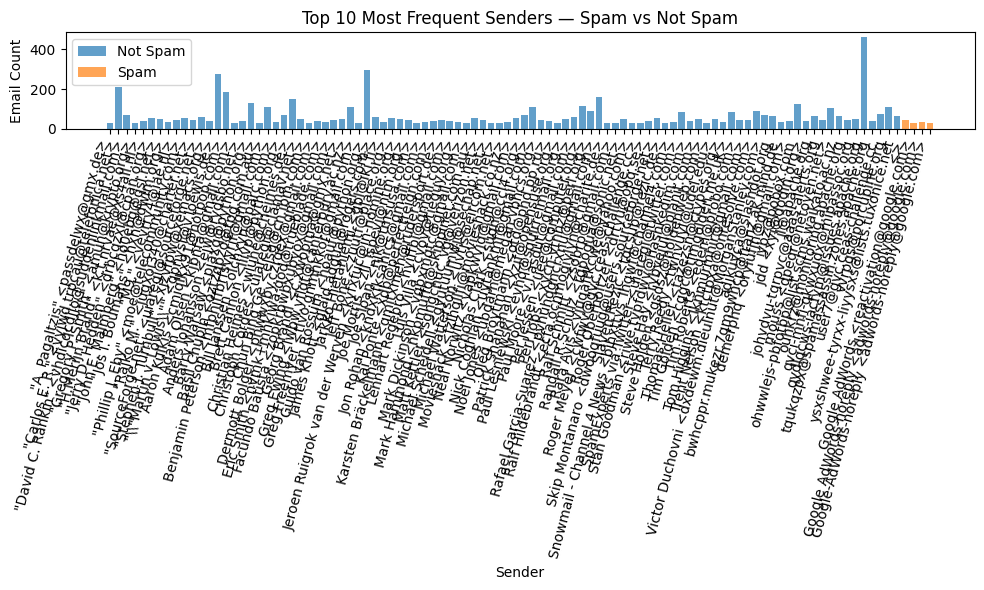

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# visulizing if the sender column is an indicator of a spam email or not
sender_counts = (
    df.groupby(['sender', 'label'])
    .size()
    .reset_index(name='count')
)


top_senders = (
    sender_counts.groupby('sender')['count'].sum()
    .sort_values(ascending=False)
    .head(100)
    .index
)


top_data = sender_counts[sender_counts['sender'].isin(top_senders)]


plt.figure(figsize=(10,6))
for label_value, label_name in [(0, "Not Spam"), (1, "Spam")]:
    subset = top_data[top_data['label'] == label_value]
    plt.bar(
        subset['sender'],
        subset['count'],
        label=label_name,
        alpha=0.7
    )

plt.title("Top 10 Most Frequent Senders — Spam vs Not Spam")
plt.xlabel("Sender")
plt.ylabel("Email Count")
plt.xticks(rotation=75, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


### 1.apreantally sender email isnt an indicatiorso will drop the column then !

### 2.ill check if a reciver gets more skammed than the rest that could be an indicator if the peron is irrsponsible with thier email and the put it every where

In [15]:
# 1. Count total and spam per receiver
receiver_stats = (
    df.groupby('receiver')['label']
      .agg(receiver_total_emails='count',
           receiver_spam_count='sum') #counting if spam increments 1 and if ham its just Zero nothing changes
      .reset_index()
)

# 2. Compute spam ratio
receiver_stats['receiver_spam_ratio'] = (
    receiver_stats['receiver_spam_count'] / receiver_stats['receiver_total_emails']
)


df = df.merge(receiver_stats, on='receiver', how='left')
df.head()

,sender,receiver,date,subject,body,label,urls,receiver_total_emails,receiver_spam_count,receiver_spam_ratio
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,424,424,1.000000
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...,1,1,922,894,0.969631
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,379,378,0.997361
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,3,0,0.000000
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iwf...,1,1,922,894,0.969631


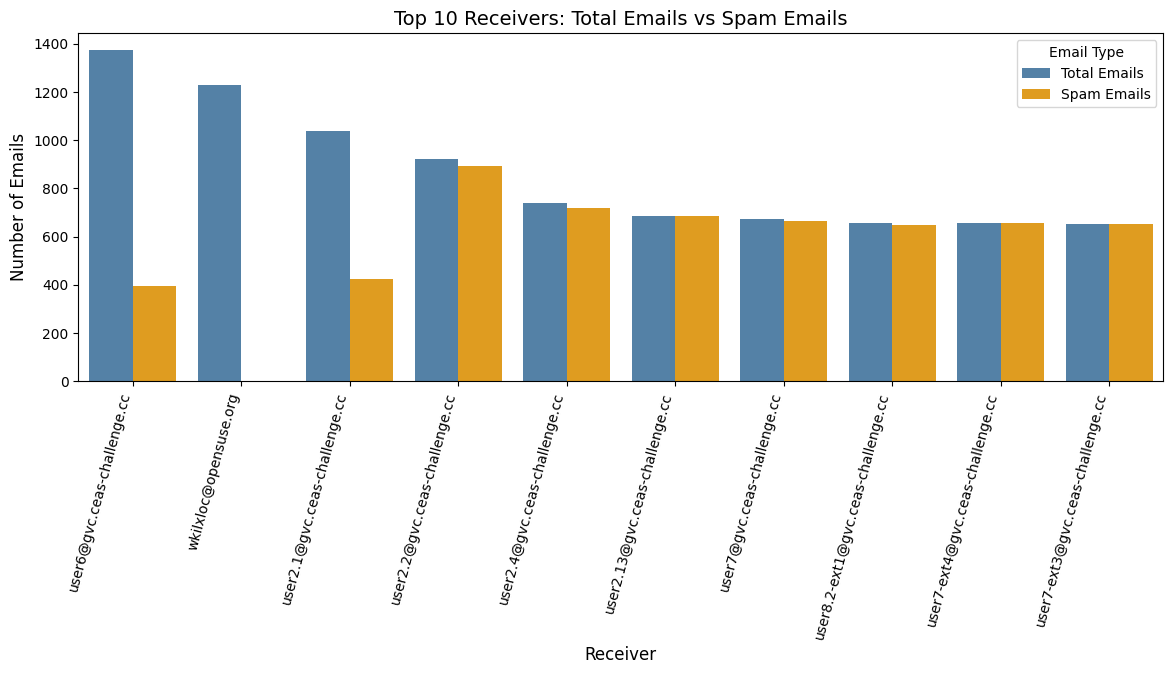

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pick top 10 receivers by total emails: they recived most emails
top_receivers = df[['receiver', 'receiver_total_emails', 'receiver_spam_count']].drop_duplicates()
top_receivers = top_receivers.sort_values('receiver_total_emails', ascending=False).head(10)

# Melt the dataframe for seaborn
plot_data = top_receivers.melt(
    id_vars='receiver', 
    value_vars=['receiver_total_emails', 'receiver_spam_count'],
    var_name='Email Type', 
    value_name='Count'
)

# Rename for clear legend
plot_data['Email Type'] = plot_data['Email Type'].replace({
    'receiver_total_emails': 'Total Emails',
    'receiver_spam_count': 'Spam Emails'
})

# Plot with custom colors
plt.figure(figsize=(14,6))
sns.barplot(
    data=plot_data, 
    x='receiver', 
    y='Count', 
    hue='Email Type',
    palette={'Total Emails': 'steelblue', 'Spam Emails': 'orange'}
)
plt.xticks(rotation=75, ha='right')
plt.title("Top 10 Receivers: Total Emails vs Spam Emails", fontsize=14)
plt.xlabel("Receiver", fontsize=12)
plt.ylabel("Number of Emails", fontsize=12)
plt.legend(title='Email Type')
plt.subplots_adjust(bottom=0.3)  # ensures rotated labels fit
plt.show()


receiver_total_emails by itself is not very predictive

It mostly measures activity of the receiver, not spam likelihood.

receiver_spam_count by itself is also not ideal

It’s just counting past spam, but for unseen emails in a model you won’t know future spam counts.

Better feature: receiver_spam_ratio (spam / total)

Normalizes the spam by total emails for that receiver.

Captures whether a receiver is “spam-heavy” relative to their total emails.

This is what can help the model learn patterns.
### so will drop total and spam count and keep the ratio 

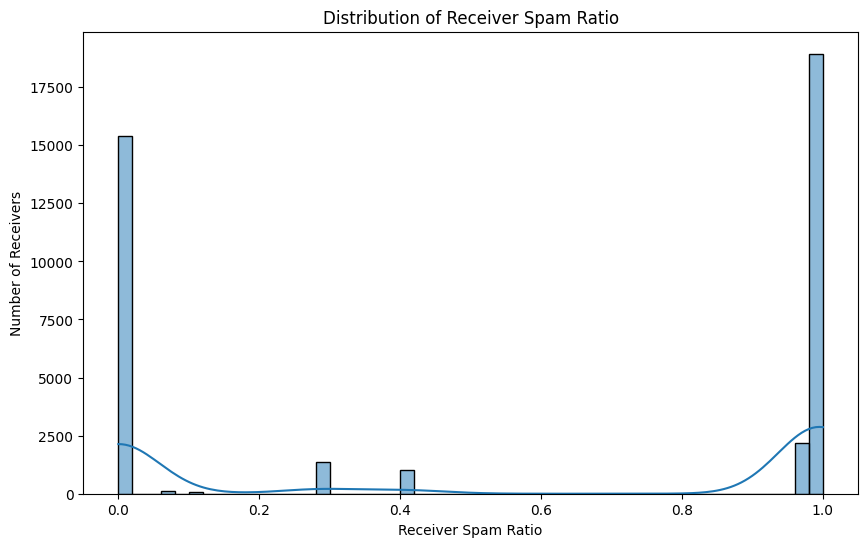

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df['receiver_spam_ratio'], bins=50, kde=True)
plt.title('Distribution of Receiver Spam Ratio')
plt.xlabel('Receiver Spam Ratio')
plt.ylabel('Number of Receivers')
plt.show()


## the spam ratio feature gave us some clusters of recivers so i assume the ratio is a good indicator of spam

#### exracting features from the date column,the date it self isnt a clear indicator how ever if its a spam could it come in common hour acrross data? lets see

| Feature                                    | Why useful for spam                                |
| ------------------------------------------ | -------------------------------------------------- |
| **Hour of the day**                        | Spam may be more frequent at certain hours         |
| **Day of week** (`Tuesday`)                | Some spam campaigns target weekdays vs weekends    |
| **Is weekend** (True/False)                | Quick binary check for weekend vs weekday patterns |
| **Month or season**                        | Some spam spikes in holidays or certain months     |


In [18]:
import pandas as pd

# 1: Convert to datetime, handle errors and mixed timezones
df['date_clean'] = pd.to_datetime(df['date'], errors='coerce', utc=True) #it has a time zone

# 2: Drop rows that couldn't be parsed
df = df.dropna(subset=['date_clean'])

# 3: Extract features
df['hour'] = df['date_clean'].dt.hour
df['day_of_week'] = df['date_clean'].dt.day_name()
df['is_weekend'] = df['date_clean'].dt.weekday >= 5  # True if Saturday/Sunday USA weekends

print(df[['date', 'date_clean', 'hour', 'day_of_week', 'is_weekend']].head())


                              date                date_clean  hour  \
0  Tue, 05 Aug 2008 16:31:02 -0700 2008-08-05 23:31:02+00:00    23   
1  Tue, 05 Aug 2008 18:31:03 -0500 2008-08-05 23:31:03+00:00    23   
2  Tue, 05 Aug 2008 20:28:00 -1200 2008-08-06 08:28:00+00:00     8   
3  Tue, 05 Aug 2008 17:31:20 -0600 2008-08-05 23:31:20+00:00    23   
4  Tue, 05 Aug 2008 19:31:21 -0400 2008-08-05 23:31:21+00:00    23   

  day_of_week  is_weekend  
0     Tuesday       False  
1     Tuesday       False  
2   Wednesday       False  
3     Tuesday       False  
4     Tuesday       False  


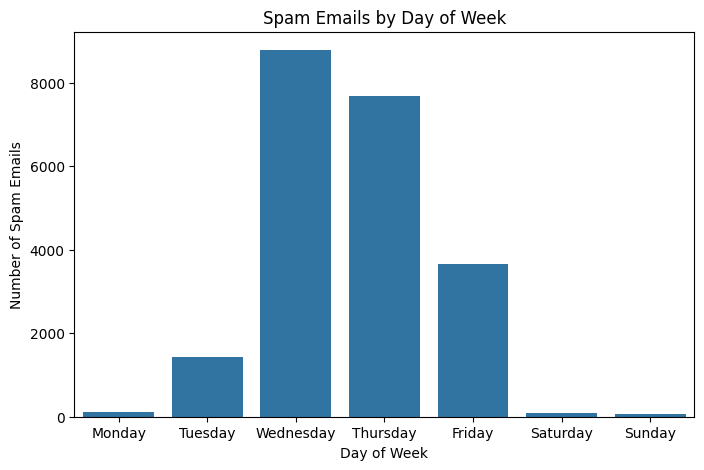

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only spam emails
spam_df = df[df['label'] == 1]

# Count by day of week
plt.figure(figsize=(8,5))
sns.countplot(x='day_of_week', data=spam_df,
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Spam Emails by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Spam Emails')
plt.show()


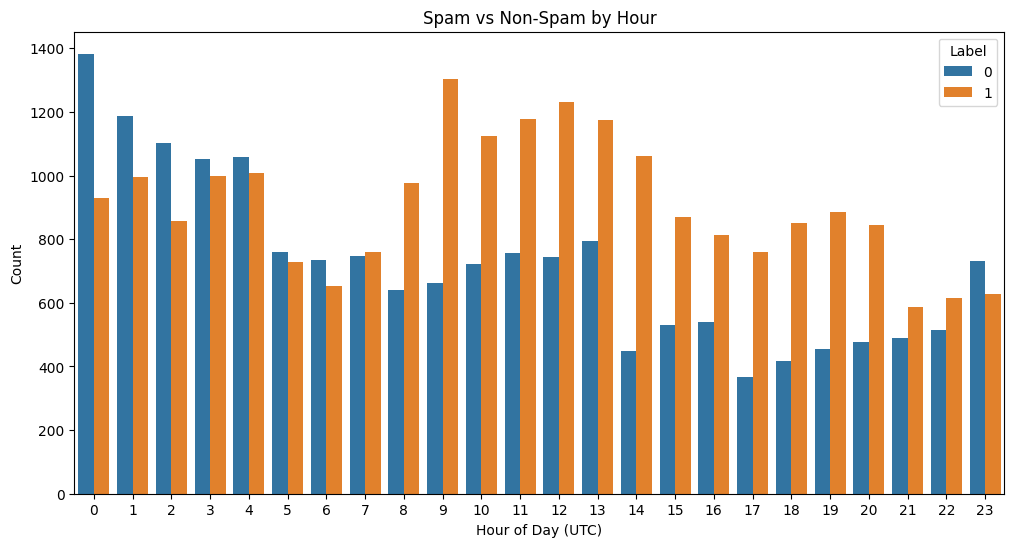

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.countplot(x='hour', hue='label', data=df)
plt.title('Spam vs Non-Spam by Hour')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Count')
plt.legend(title='Label', loc='upper right')
plt.show()


In [22]:
print("Spam count by hour:")
print(df[df['label']==1]['hour'].value_counts().sort_index())

print("\nSpam count by day_of_week:")
print(df[df['label']==1]['day_of_week'].value_counts().reindex(
      ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']))


Spam count by hour:
hour
0      930
1      994
2      856
3      998
4     1007
5      727
6      653
7      759
8      977
9     1303
10    1125
11    1178
12    1230
13    1174
14    1063
15     869
16     813
17     761
18     852
19     886
20     844
21     586
22     614
23     628
Name: count, dtype: int64

Spam count by day_of_week:
day_of_week
Monday        111
Tuesday      1441
Wednesday    8785
Thursday     7689
Friday       3662
Saturday       82
Sunday         57
Name: count, dtype: int64


# Observations

### Hour: Spam is higher roughly between 9–14 (UTC), so there’s a clear cluster of high activity will use it as a feature.

### Day of week: Most spam occurs Wednesday–Thursday, some on Tuesday, almost none on the weekend will use it as a feature.

In [23]:
df.head()

,sender,receiver,date,subject,body,label,urls,receiver_total_emails,receiver_spam_count,receiver_spam_ratio,date_clean,hour,day_of_week,is_weekend
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,424,424,1.000000,2008-08-05 23:31:02+00:00,23,Tuesday,False
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...,1,1,922,894,0.969631,2008-08-05 23:31:03+00:00,23,Tuesday,False
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,379,378,0.997361,2008-08-06 08:28:00+00:00,8,Wednesday,False
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,3,0,0.000000,2008-08-05 23:31:20+00:00,23,Tuesday,False
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iwf...,1,1,922,894,0.969631,2008-08-05 23:31:21+00:00,23,Tuesday,False


In [24]:
cols_to_drop = ['sender', 'receiver','date', 'receiver_total_emails','receiver_spam_count','date_clean','is_weekend']
df.drop(cols_to_drop, axis=1, inplace=True)


In [25]:
df.head()

,subject,body,label,urls,receiver_spam_ratio,hour,day_of_week
0,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,1.000000,23,Tuesday
1,Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...,1,1,0.969631,23,Tuesday
2,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,0.997361,8,Wednesday
3,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,0.000000,23,Tuesday
4,SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iwf...,1,1,0.969631,23,Tuesday


---

### Step 5: Text Preprocessing(Rahaf & Rawan) 

---

### Step 6: Text Representation (Vectorization) (Salha) 

---
---

# pre-process flow مسودة ونوتات ريناد

### sender / receiver: Optional to keep, mostly metadata

### subject / body: Critical for spam detection.

### Missing body → drop row  or replace with empty string?.

### Missing subject → replace with empty string.

### urls / label: Must not be missing. Drop any row missing these.

### 2. Feature Extraction / Engineering
### 1. Combine subject + body into a single text field for modeling i think for text represention as a vector
### 2. extract text length as a numeric feature a new column
### 3. maybe another column that counts a word occurence and all captical words in a text
### 4. Sender/Receiver metadata (optional)

### Could extract domains from email addresses: "gmail.com", "yahoo.com", etc.

### Could count frequency of sender → some frequent spammers.

# 3. Text Preprocessing (NLP)

### This is key for the text column (subject + body): i think we should combine it

### 1.Cleaning

### Remove HTML tags, punctuation, extra whitespace.

### Keep uppercase info optionally (important for spam detection).

### 2.Tokenization

### Split text into words.

### Stopword handling

### Optional: sometimes keeping stopwords is better for spam detection.?

### 3.Stemming / Lemmatization idk maybe not? for better detection ?


### 4.Feature representation

### Convert to numeric vectors: TF-IDF, Bag-of-Words, or word embeddings for model input.